In [34]:
import os
import zipfile
import itertools
import numpy as np
import pandas as pd 
from numbers import Number
import sqlite3
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
from collections import Counter
warnings.filterwarnings('ignore')

import pickle

# SQL Data
> - Unzipping file (im.db.zip), making a connection, conn and assigning a cursor
> - Opening file as a dataframe
> - Creating a single table with relevant data for us to use:

In [35]:
# Check if 'im.db' exists, unzip if it doesn't
if not os.path.exists('zippedData/im.db'):
    with zipfile.ZipFile('zippedData/im.db.zip', 'r') as zip_ref:
        zip_ref.extractall('zippedData')

# Connect to the SQLite database
conn = sqlite3.connect('zippedData/im.db')

In [36]:
cursor = conn.cursor()

In [37]:
pd.read_sql("""
  SELECT *
  FROM sqlite_master  
  """, conn)

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


# SQL Data Cleaning and Joining
> > - Movie_ID, Genres, Avg_Rating, Num_Votes, Region, Category, Artist_Name, Screen_Time, and Movie_Title
> > - Where region is United States with Number of votes greater than 1000 and Average rating is 6 and above
> > - Removed all duplicates from our joining point primary key Movie_ID and foreign Key Person_ID

In [38]:
#Select relevant data for computation and set certain cleaning papmeters such as region = US, Death_year Is null and avgrating >=6
final_q = pd.read_sql("""
SELECT mb.movie_id, mb.genres, mr.averagerating AS avg_ratings, mr.numvotes AS num_votes, mk.region, 
pr.category, p.primary_name AS artist_name, mb.runtime_minutes AS screen_time, mb.primary_title AS movie_title, p.death_year
FROM movie_basics mb
JOIN movie_akas mk ON mk.movie_id = mb.movie_id
JOIN movie_ratings mr ON mr.movie_id = mb.movie_id
JOIN principals pr ON pr.movie_id = mb.movie_id
JOIN persons p ON p.person_id = pr.person_id
WHERE mk.region != 'None'
AND p.death_year IS NULL
;""", conn)
#More cleaning using pandas, dropped duplicates, set the defining catagories and dropped missing/empty values from Genre
final_q = final_q.drop_duplicates(subset=['movie_id'])
# Removing duplicate movie names
final_q = final_q.drop_duplicates(subset=['movie_title'])
final_q = final_q.dropna(subset=['genres'])
categories_of_interest = ['actor', 'actress', 'writer', 'director', 'producer']
final_q = final_q[final_q['category'].isin(categories_of_interest)]
#Created a weighted average for rating
final_q['weighted_avg'] = (final_q['avg_ratings'] * final_q['num_votes']) / final_q['num_votes'].sum()
final_q

,movie_id,genres,avg_ratings,num_votes,region,category,artist_name,screen_time,movie_title,death_year,weighted_avg
0,tt0369610,"Action,Adventure,Sci-Fi",7.0,539338,BG,producer,Patrick Crowley,124.0,Jurassic World,None,1.666936e-02
423,tt0381957,Drama,7.6,23,GB,actor,Derek Jacobi,92.0,Cloud Cuckoo Land,None,7.717939e-07
433,tt0401729,"Action,Adventure,Sci-Fi",6.6,241792,UA,actor,Willem Dafoe,132.0,John Carter,None,7.046051e-03
750,tt10084780,"Drama,Romance",8.3,30,IN,director,Sateesh Chandra Nadella,NaN,Vinara sodara veera kumara,None,1.099409e-06
760,tt1014759,"Adventure,Family,Fantasy",6.5,358813,IE,actor,Johnny Depp,108.0,Alice in Wonderland,None,1.029773e-02
...,...,...,...,...,...,...,...,...,...,...,...
1992082,tt9593792,Horror,6.1,39,TH,director,Mate Yimsomboon,NaN,Ghost Wife,None,1.050399e-06
1992100,tt9644084,Documentary,5.2,5,DE,director,Uli M. Schüppel,95.0,Der Atem,None,1.147977e-07
1992120,tt9657946,Drama,6.0,16,XWW,actor,Marcelo Di Souza,90.0,Homing,None,4.238685e-07
1992144,tt9726638,"Action,Adventure,Comedy",6.0,6,CN,actress,Carman Lee,90.0,Monkey King: The Volcano,None,1.589507e-07


# CSV Files
> - Uploaded Zipped csv files and printed columns
> - Dropped Not needed columns from each file
> - Decide to also drop data with more that 50% of value missing

In [39]:
# Reading the movie info data
movie_info = pd.read_csv('zippedData/rt.movie_info.tsv.gz', sep='\t', compression='gzip')

# Dropping unnecessary columns from movie info data
movie_info_drop = ['box_office', 'currency', 'dvd_date', 'studio']
movie_info = movie_info.drop(columns=movie_info_drop)

# Printing the columns of movie info data
print("movie_info columns:")
print(list(movie_info.columns))
print()

# Reading the movie gross data
movie_gross = pd.read_csv('zippedData/bom.movie_gross.csv.gz')

# Printing the columns of movie gross data
print("movie_gross columns:")
print(list(movie_gross.columns))
print()

# Reading the movie budget data
movie_budget = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')

# Printing the columns of movie budget data
print("movie_budget columns:")
print(list(movie_budget.columns))
print()

# Reading the movie reviews data
movie_reviews = pd.read_csv('zippedData/rt.reviews.tsv.gz', sep='\t', compression='gzip', encoding='latin-1')

# Dropping unnecessary column from movie reviews data
movie_review_drop = ['rating']
movie_reviews = movie_reviews.drop(columns=movie_review_drop)

# Printing the columns of movie reviews data
print("movie_reviews columns:")
print(list(movie_reviews.columns))
print()

# Reading the tmdb movie data
tmbd_movie = pd.read_csv('zippedData/tmdb.movies.csv.gz')

# Printing the columns of tmdb movie data
print("tmbd_movie columns:")
print(list(tmbd_movie.columns))
print()

movie_info columns:
['id', 'synopsis', 'rating', 'genre', 'director', 'writer', 'theater_date', 'runtime']

movie_gross columns:
['title', 'studio', 'domestic_gross', 'foreign_gross', 'year']

movie_budget columns:
['id', 'release_date', 'movie', 'production_budget', 'domestic_gross', 'worldwide_gross']

movie_reviews columns:
['id', 'review', 'fresh', 'critic', 'top_critic', 'publisher', 'date']

tmbd_movie columns:
['Unnamed: 0', 'genre_ids', 'id', 'original_language', 'original_title', 'popularity', 'release_date', 'title', 'vote_average', 'vote_count']



# Movie Budget Cleaning
> - After analysing the CSV, we decided to use the Movie Budge data
> - We cleaned the data removing comma's and $ sign, assigning the column as integer
> - We removed duplicated from movies column to ease merging with SQL data
> - Calculated needed number to compute profit and budget better, and created columns for each such as ROI

In [40]:
# Converting release_date column to datetime format
movie_budget["release_date"] = pd.to_datetime(movie_budget["release_date"])

# Extracting release year and month from release_date
movie_budget["release_year"] = movie_budget["release_date"].dt.year
movie_budget["release_month"] = movie_budget["release_date"].dt.month

# Removing commas and dollar signs, and converting production_budget, domestic_gross, and worldwide_gross columns to integer format
movie_budget["production_budget"] = movie_budget["production_budget"].str.replace(",", "").str.replace("$", "").astype("int64")
movie_budget["domestic_gross"] = movie_budget["domestic_gross"].str.replace(",", "").str.replace("$", "").astype("int64")
movie_budget["worldwide_gross"] = movie_budget["worldwide_gross"].str.replace(",", "").str.replace("$", "").astype("int64")

# Removing duplicate movie names 
movie_budget = movie_budget.drop_duplicates(subset=['movie'])

# Removing rows where worldwide_gross is 0
movie_budget = movie_budget[movie_budget['worldwide_gross'] != 0]

# Calculating foreign_gross as the difference between worldwide_gross and domestic_gross
movie_budget["foreign_gross"] = movie_budget["worldwide_gross"] - movie_budget["domestic_gross"]

# Calculating total_profit as the difference between worldwide_gross and production_budget
movie_budget["total_profit"] = movie_budget["worldwide_gross"] - movie_budget["production_budget"]

# Calculating ROI (Return on Investment) as the ratio of worldwide_gross to production_budget multiplied by 100
movie_budget['ROI'] = (movie_budget['worldwide_gross'] / movie_budget['production_budget']) * 100

# Merge Movie_Budget with Merged_SQL

In [41]:
# merge movie_basics and movie_budget on movie and primary_title
final_data = pd.merge(final_q, movie_budget, left_on="movie_title", right_on="movie", how="inner")

> - Seperating and analysing the Genre column
> - We made the first listed genre the main genre for further analysis
> - We found the 5 most appearing Genre with highest ratings

In [42]:
#Extracts first genre in the list as main genre
def get_main_genre(x):
    genres = x.split(',')
    main_genre = genres[0]
    return main_genre
final_data['main_genre'] = final_data['genres'].apply(lambda x: get_main_genre(x))
final_data

,movie_id,genres,avg_ratings,num_votes,region,category,artist_name,screen_time,movie_title,death_year,...,movie,production_budget,domestic_gross,worldwide_gross,release_year,release_month,foreign_gross,total_profit,ROI,main_genre
0,tt0369610,"Action,Adventure,Sci-Fi",7.0,539338,BG,producer,Patrick Crowley,124.0,Jurassic World,None,...,Jurassic World,215000000,652270625,1648854864,2015,6,996584239,1433854864,766.909239,Action
1,tt0401729,"Action,Adventure,Sci-Fi",6.6,241792,UA,actor,Willem Dafoe,132.0,John Carter,None,...,John Carter,275000000,73058679,282778100,2012,3,209719421,7778100,102.828400,Action
2,tt1014759,"Adventure,Family,Fantasy",6.5,358813,IE,actor,Johnny Depp,108.0,Alice in Wonderland,None,...,Alice in Wonderland,200000000,334191110,1025491110,2010,3,691300000,825491110,512.745555,Adventure
3,tt1194173,"Action,Adventure,Thriller",6.7,268678,RS,actor,Scott Glenn,135.0,The Bourne Legacy,None,...,The Bourne Legacy,125000000,113203870,280355920,2012,8,167152050,155355920,224.284736,Action
4,tt1219289,"Mystery,Sci-Fi,Thriller",7.4,492490,AR,actor,Robert De Niro,105.0,Limitless,None,...,Limitless,27000000,79249455,155564919,2011,3,76315464,128564919,576.166367,Mystery
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1712,tt3829266,"Action,Adventure,Sci-Fi",5.4,94888,LT,director,Shane Black,107.0,The Predator,None,...,The Predator,88000000,51024708,159487563,2018,9,108462855,71487563,181.235867,Action
1713,tt4651520,Comedy,6.2,100952,UA,actress,Christina Applegate,100.0,Bad Moms,None,...,Bad Moms,20000000,113257297,180998716,2016,7,67741419,160998716,904.993580,Comedy
1714,tt5462602,"Comedy,Drama,Romance",7.6,104008,NO,actress,Holly Hunter,120.0,The Big Sick,None,...,The Big Sick,5000000,42872467,53972860,2017,6,11100393,48972860,1079.457200,Comedy
1715,tt5649108,"Comedy,Crime,Drama",6.7,25098,FR,producer,Nat Faxon,92.0,Thoroughbreds,None,...,Thoroughbreds,5000000,3072605,3187302,2018,3,114697,-1812698,63.746040,Comedy


## Genres 

In [43]:
# Convert 'genres' to string and then split
final_data['genres'] = final_data['genres'].astype(str).str.split(',')
# Explode the 'genres' column
final_data_exp = final_data.explode('genres')

final_data_exp

,movie_id,genres,avg_ratings,num_votes,region,category,artist_name,screen_time,movie_title,death_year,...,movie,production_budget,domestic_gross,worldwide_gross,release_year,release_month,foreign_gross,total_profit,ROI,main_genre
0,tt0369610,Action,7.0,539338,BG,producer,Patrick Crowley,124.0,Jurassic World,None,...,Jurassic World,215000000,652270625,1648854864,2015,6,996584239,1433854864,766.909239,Action
0,tt0369610,Adventure,7.0,539338,BG,producer,Patrick Crowley,124.0,Jurassic World,None,...,Jurassic World,215000000,652270625,1648854864,2015,6,996584239,1433854864,766.909239,Action
0,tt0369610,Sci-Fi,7.0,539338,BG,producer,Patrick Crowley,124.0,Jurassic World,None,...,Jurassic World,215000000,652270625,1648854864,2015,6,996584239,1433854864,766.909239,Action
1,tt0401729,Action,6.6,241792,UA,actor,Willem Dafoe,132.0,John Carter,None,...,John Carter,275000000,73058679,282778100,2012,3,209719421,7778100,102.828400,Action
1,tt0401729,Adventure,6.6,241792,UA,actor,Willem Dafoe,132.0,John Carter,None,...,John Carter,275000000,73058679,282778100,2012,3,209719421,7778100,102.828400,Action
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1715,tt5649108,Crime,6.7,25098,FR,producer,Nat Faxon,92.0,Thoroughbreds,None,...,Thoroughbreds,5000000,3072605,3187302,2018,3,114697,-1812698,63.746040,Comedy
1715,tt5649108,Drama,6.7,25098,FR,producer,Nat Faxon,92.0,Thoroughbreds,None,...,Thoroughbreds,5000000,3072605,3187302,2018,3,114697,-1812698,63.746040,Comedy
1716,tt6139732,Adventure,7.4,57549,SI,actor,Will Smith,128.0,Aladdin,None,...,Aladdin,182000000,246734314,619234314,2019,5,372500000,437234314,340.238634,Adventure
1716,tt6139732,Comedy,7.4,57549,SI,actor,Will Smith,128.0,Aladdin,None,...,Aladdin,182000000,246734314,619234314,2019,5,372500000,437234314,340.238634,Adventure


## Release month vs genres ( in terms of ROI) 

In [46]:
roi_genre_month = final_data_exp.groupby(['genres', 'release_month'])['ROI'].mean()
roi_genre_month

genres   release_month
Action   1                337.669251
         2                275.064732
         3                224.821161
         4                341.631539
         5                304.615544
                             ...    
Western  7                 94.546224
         9                 91.589492
         10                27.051267
         11                51.359819
         12               397.003916
Name: ROI, Length: 239, dtype: float64

- I will add graph and related things here 

##  ROI per genre

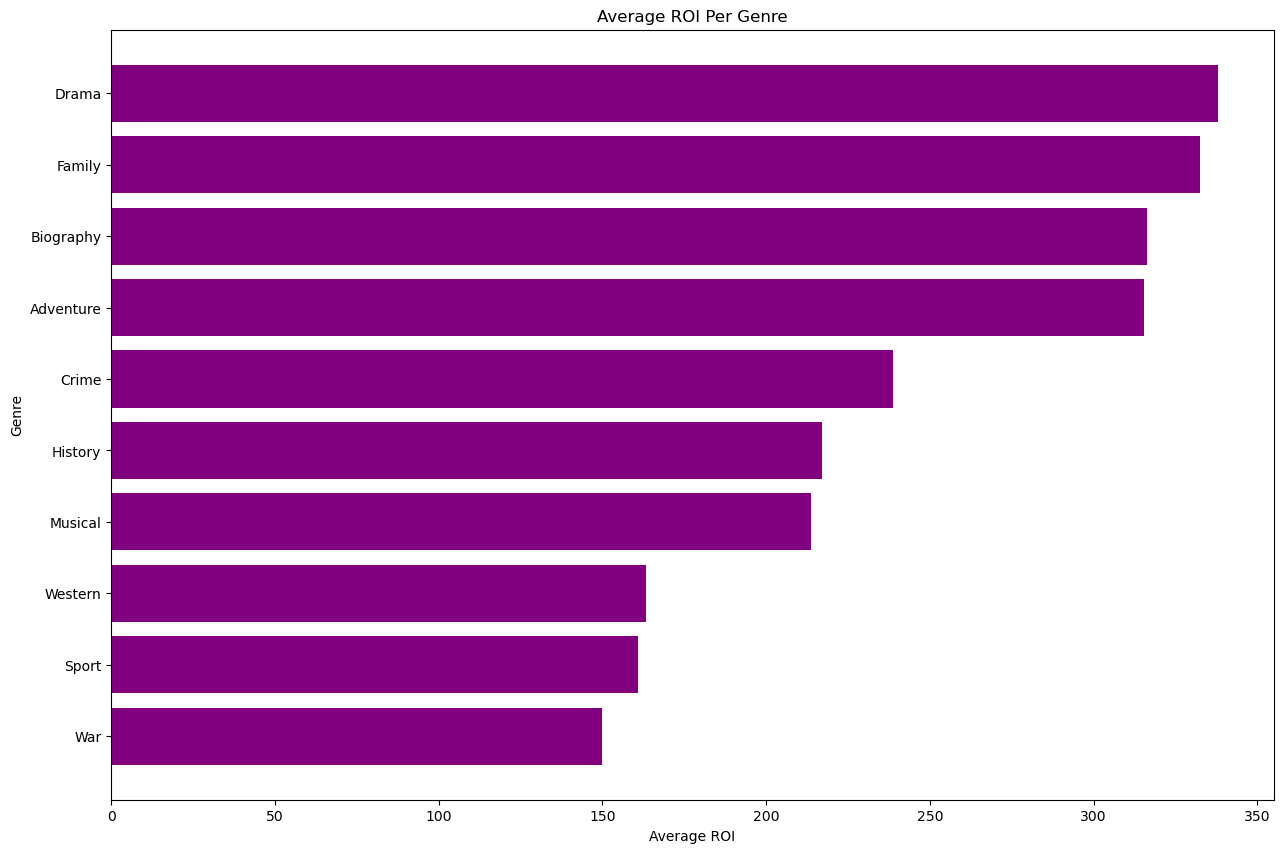

In [54]:
# Find ROI per genre
average_roi_per_genre = final_data_exp.groupby('genres')['ROI'].mean().sort_values(ascending=True).head(10).reset_index()

# Plot
plt.figure(figsize=(15, 10))
plt.barh(average_roi_per_genre['genres'], average_roi_per_genre['ROI'], color='purple')
plt.xlabel('Average ROI')
plt.ylabel('Genre')
plt.title('Average ROI Per Genre')
plt.show()

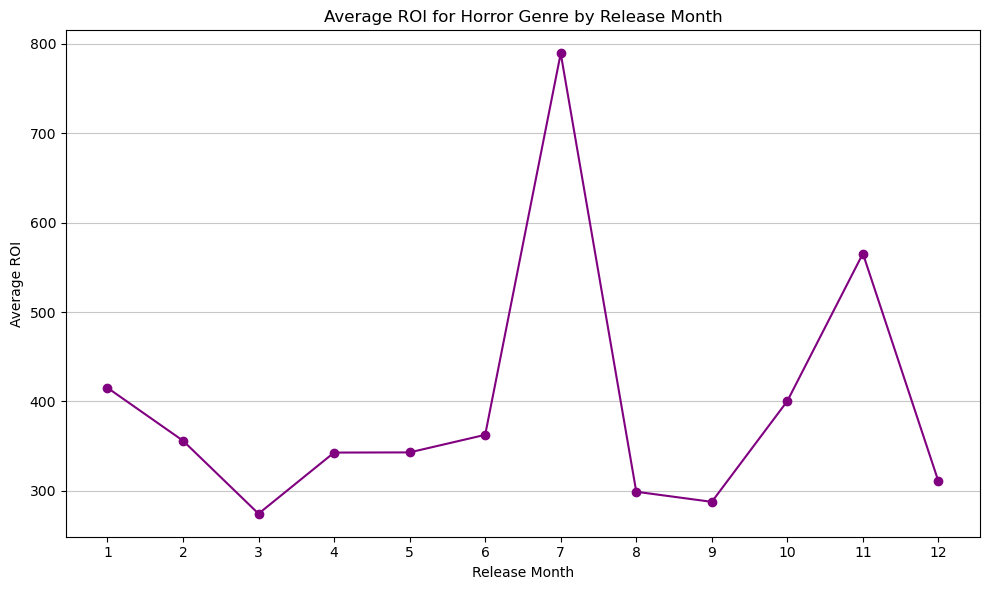

In [51]:
# Create a line chart
plt.figure(figsize=(10, 6))
# Calculate the average ROI for the "Horror" genre by release month
roi_genre_month_horror = final_data_exp.groupby(['release_month'])['ROI'].mean()

plt.plot(roi_genre_month_horror.index, roi_genre_month_horror.values, marker='o', color='purple', linestyle='-')
plt.xlabel('Release Month')
plt.ylabel('Average ROI')
plt.title('Average ROI for Horror Genre by Release Month')
plt.xticks(range(1, 13))  # Assuming release_month is represented as integers from 1 to 12
plt.grid(axis='y', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()


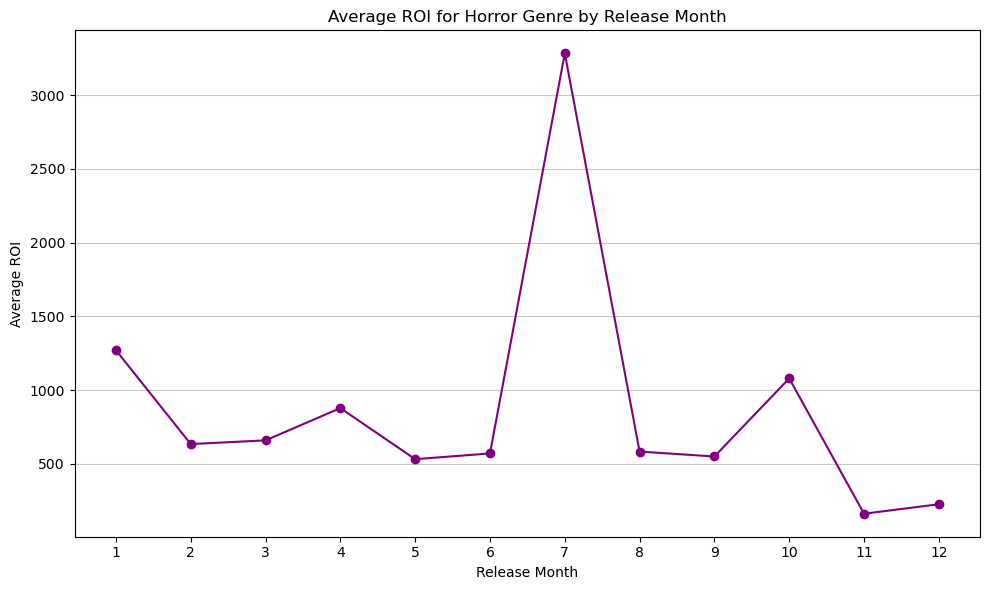

In [56]:
# Create a line chart
plt.figure(figsize=(10, 6))

# Calculate the average ROI for the "Horror" genre by release month
roi_genre_month_horror = final_data_exp[final_data_exp['genres'] == 'Horror'].groupby(['release_month'])['ROI'].mean()

plt.plot(roi_genre_month_horror.index, roi_genre_month_horror.values, marker='o', color='purple', linestyle='-')
plt.xlabel('Release Month')
plt.ylabel('Average ROI')
plt.title('Average ROI for Horror Genre by Release Month')
plt.xticks(range(1, 13))  # Assuming release_month is represented as integers from 1 to 12
plt.grid(axis='y', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()


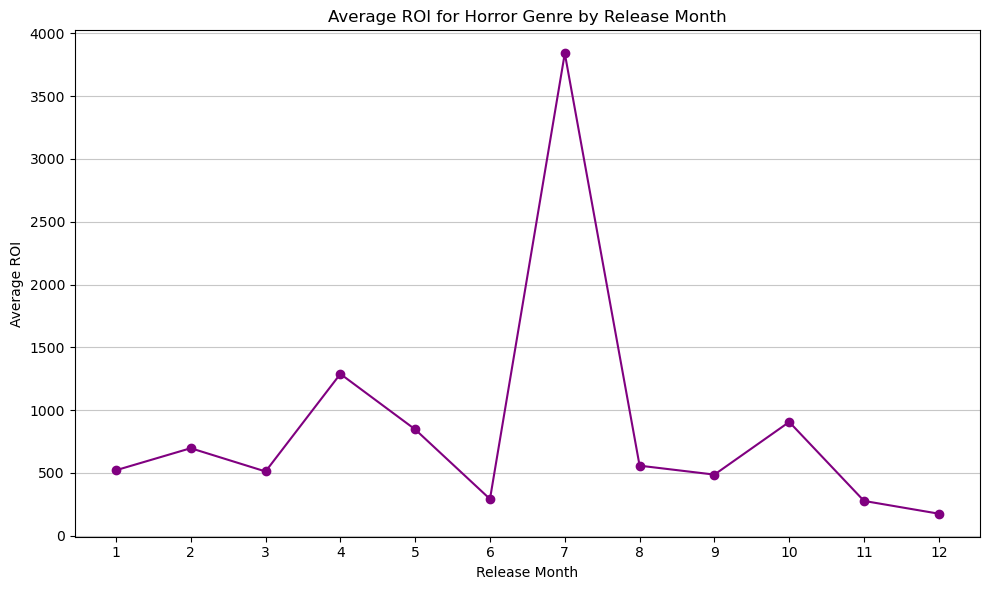

In [58]:
# Create a line chart
plt.figure(figsize=(10, 6))

# Calculate the average ROI for the "Horror" genre by release month
roi_genre_month_horror = final_data_exp[final_data_exp['genres'] == 'Mystery'].groupby(['release_month'])['ROI'].mean()

plt.plot(roi_genre_month_horror.index, roi_genre_month_horror.values, marker='o', color='purple', linestyle='-')
plt.xlabel('Release Month')
plt.ylabel('Average ROI')
plt.title('Average ROI for Horror Genre by Release Month')
plt.xticks(range(1, 13))  # Assuming release_month is represented as integers from 1 to 12
plt.grid(axis='y', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()


## Top 10 genres based on ROI

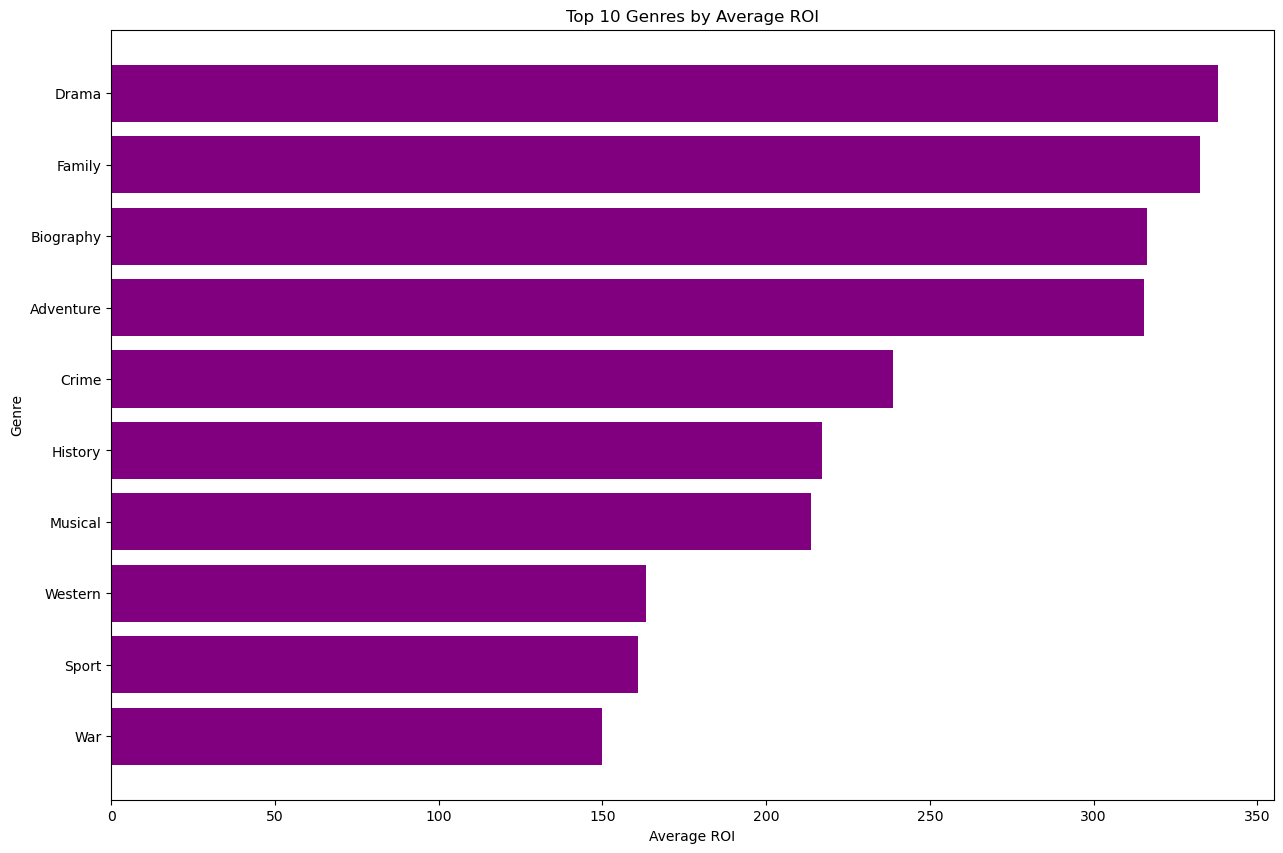

In [28]:
top_10_genres_roi = average_roi_per_genre.sort_values(by='ROI', ascending=False).head(10).reset_index()
top_10_genres_roi

plt.figure(figsize=(15, 10))
plt.barh(top_10_genres_roi ['genres'], top_10_genres_roi ['ROI'], color='purple')
plt.xlabel('Average ROI')
plt.ylabel('Genre')
plt.title('Top 10 Genres by Average ROI')
plt.gca().invert_yaxis()
plt.show()

In [57]:
# Assuming you have a DataFrame named final_data_exp with release_month as an integer column

# Filter New Year horror movies (assuming January 1st)
new_year_horror = final_data_exp[final_data_exp['release_month'] == 1]

# Filter Christmas horror movies (assuming December 25th)
christmas_horror = final_data_exp[final_data_exp['release_month'] == 12]

# Count the number of movies in each category
count_new_year_horror = len(new_year_horror)
count_christmas_horror = len(christmas_horror)

# Compare the counts
if count_new_year_horror > count_christmas_horror:
    print("New Year horror movies are more popular.")
elif count_christmas_horror > count_new_year_horror:
    print("Christmas horror movies are more popular.")
else:
    print("There's an equal number of New Year and Christmas horror movies.")


Christmas horror movies are more popular.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("fivethirtyeight")
plt.grid(False)
# Set the Seaborn style to default

# Assuming you have already calculated top_10_genres_roi
# top_10_genres_roi = average_roi_per_genre.sort_values(by='ROI', ascending=False).head(10)

# Reverse the order of the DataFrame to have the top genre at the top
top_10_genres_roi = top_10_genres_roi[::-1]

plt.figure(figsize=(15, 10))
sns.barplot(x='ROI', y='genres', data=top_10_genres_roi)
plt.xlabel('Average ROI')
plt.ylabel('Genre')
plt.title('Top 10 Genres by Average ROI')
plt.gca().invert_yaxis()
plt.show()


## Top 10 genres based on ROI and Budget 

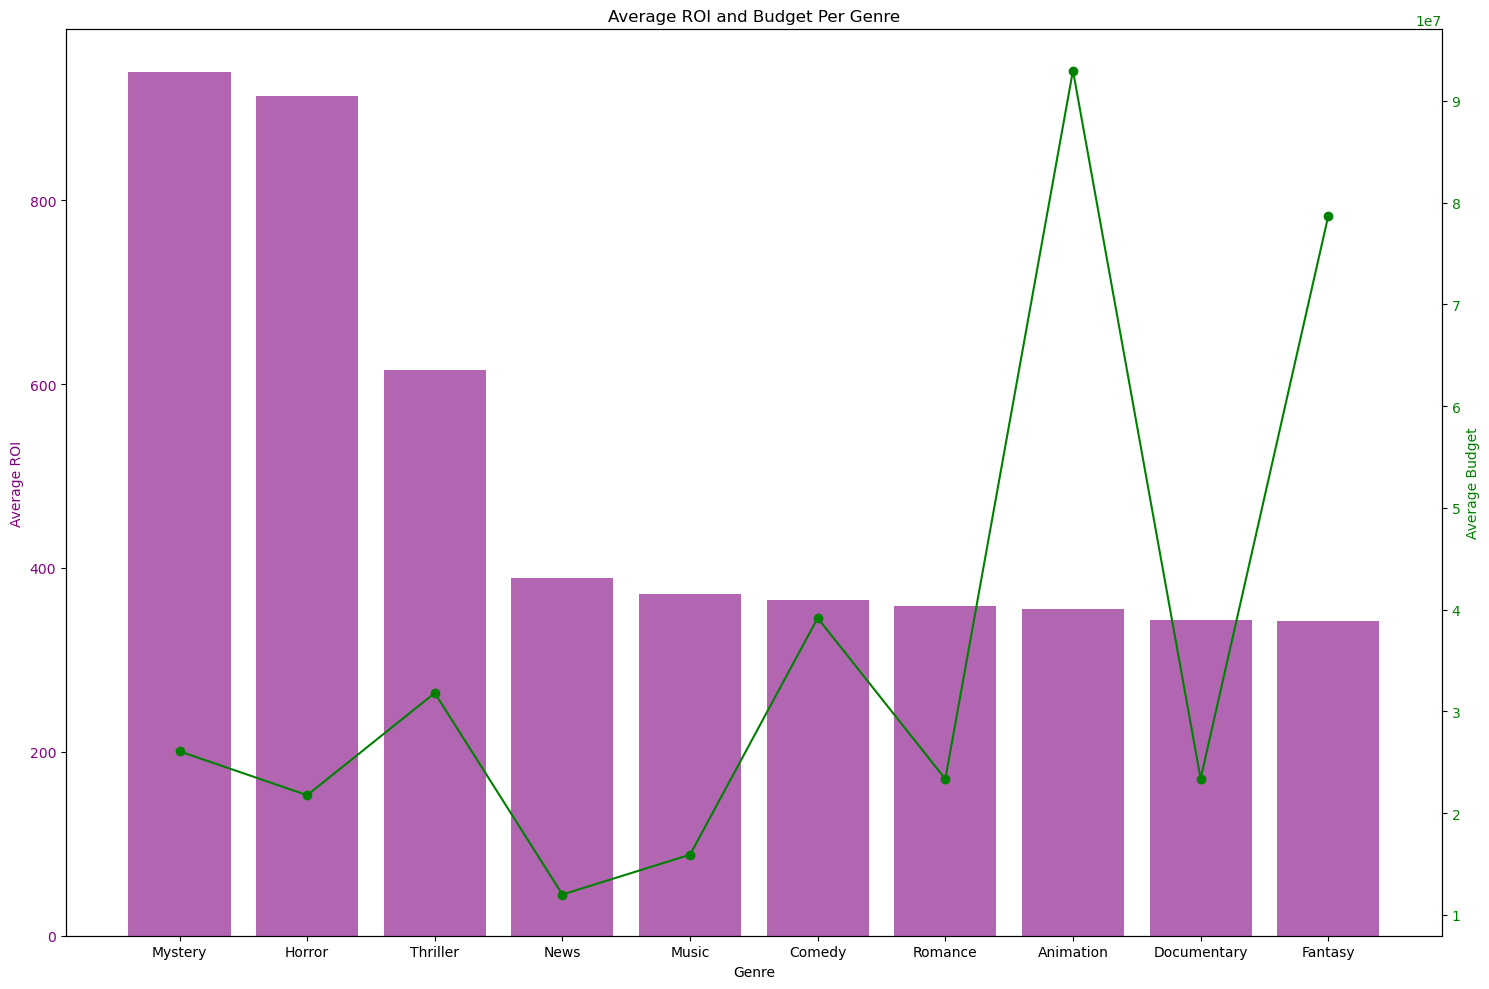

In [55]:
#Find average ROI and average Budget per genre
average_roi_and_budget_per_genre = final_data_exp.groupby('genres').agg({  'ROI': 'mean', 'production_budget': 'mean'}).sort_values(by='ROI', ascending=False).head(10).reset_index()

fig, ax1 = plt.subplots(figsize=(15, 10))

# Bar plot for ROI
ax1.bar(average_roi_and_budget_per_genre['genres'], average_roi_and_budget_per_genre['ROI'], color='purple', alpha=0.6, label='ROI')
ax1.set_xlabel('Genre')
ax1.set_ylabel('Average ROI', color='purple')
ax1.tick_params(axis='y', labelcolor='purple')

# Line plot for Budget
ax2 = ax1.twinx()
ax2.plot(average_roi_and_budget_per_genre['genres'], average_roi_and_budget_per_genre['production_budget'], color='green', marker='o', label='Budget')
ax2.set_ylabel('Average Budget', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Title and Show
plt.title('Average ROI and Budget Per Genre')
fig.tight_layout()
plt.show()


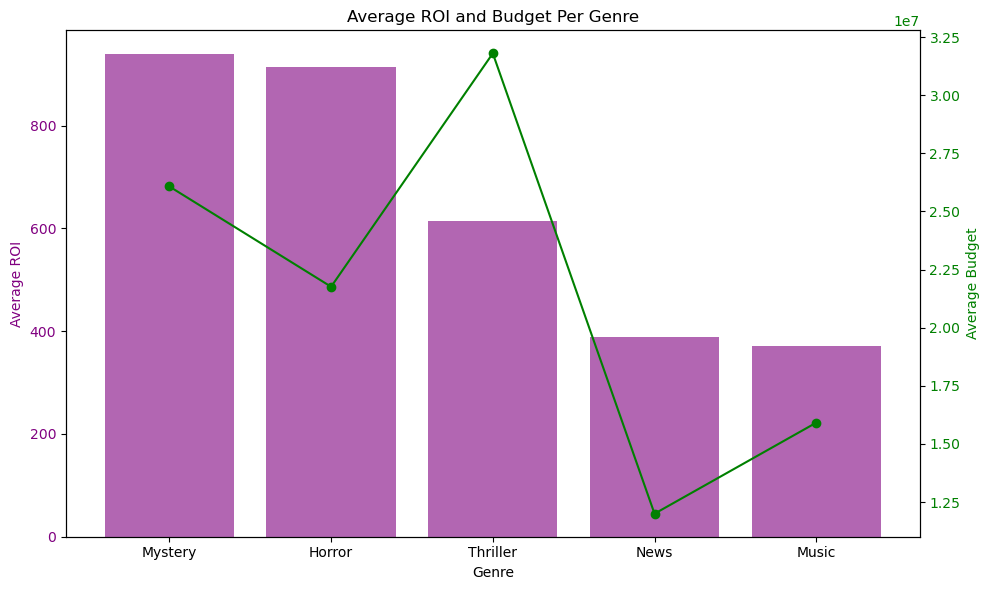

In [31]:
#Find average ROI and average Budget per genre
average_roi_and_budget_per_genre = final_data_exp.groupby('genres').agg({  'ROI': 'mean', 'production_budget': 'mean'}).sort_values(by='ROI', ascending=False).head(5).reset_index()

fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for ROI
ax1.bar(average_roi_and_budget_per_genre['genres'], average_roi_and_budget_per_genre['ROI'], color='purple', alpha=0.6, label='ROI')
ax1.set_xlabel('Genre')
ax1.set_ylabel('Average ROI', color='purple')
ax1.tick_params(axis='y', labelcolor='purple')

# Line plot for Budget
ax2 = ax1.twinx()
ax2.plot(average_roi_and_budget_per_genre['genres'], average_roi_and_budget_per_genre['production_budget'], color='green', marker='o', label='Budget')
ax2.set_ylabel('Average Budget', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Title and Show
plt.title('Average ROI and Budget Per Genre')
fig.tight_layout()
plt.show()


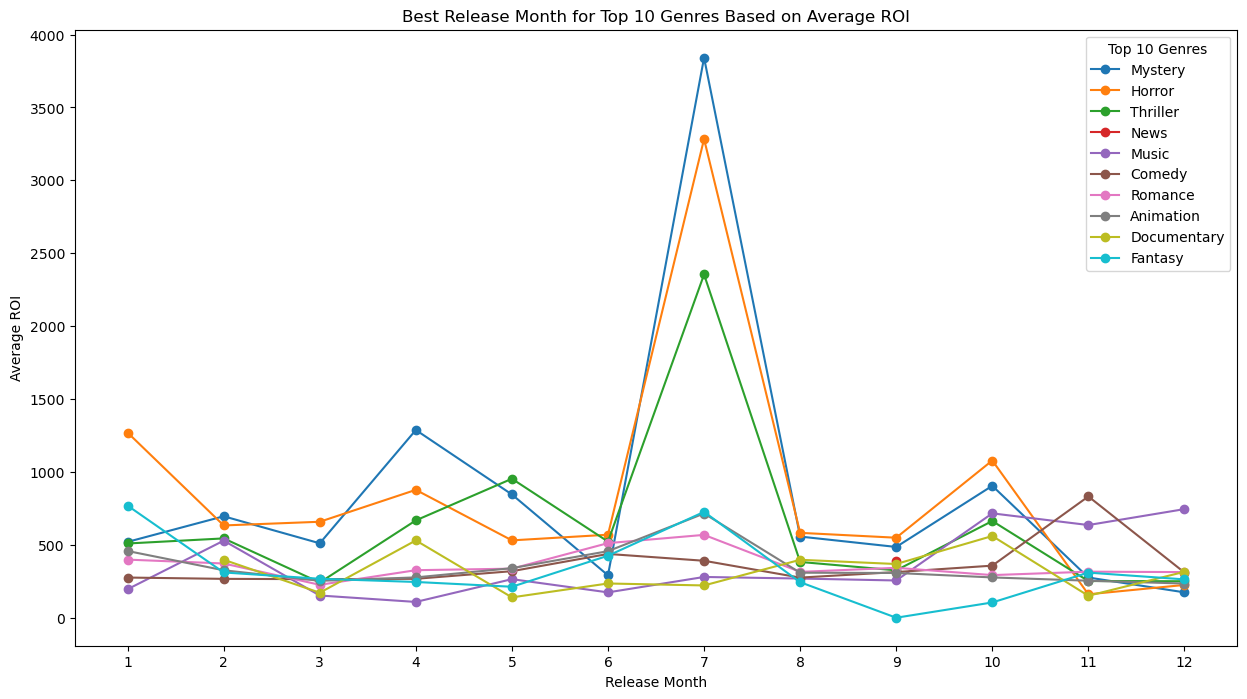

In [29]:
import matplotlib.pyplot as plt

# Calculate the top 10 genres based on average ROI
average_roi_per_genre = final_data_exp.groupby('genres')['ROI'].mean().sort_values(ascending=False).reset_index()
top_10_genres_roi = average_roi_per_genre.head(10)
top_10_genres = top_10_genres_roi['genres'].tolist()

# Assuming roi_genre_month is a Series that's the result of a groupby, you can reset the index
roi_genre_month = roi_genre_month.reset_index()

# Filter to include only genres that are in the top 10 genres based on ROI
roi_genre_month_top_10 = roi_genre_month[roi_genre_month['genres'].isin(top_10_genres)]

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(15, 8))

# Iterate through each of the top 10 genres and plot its average ROI for each release month
for genre in top_10_genres:
    genre_data = roi_genre_month_top_10[roi_genre_month_top_10['genres'] == genre]
    ax.plot(genre_data['release_month'], genre_data['ROI'], marker='o', label=genre)

# Labeling and titling the plot
ax.set_xlabel('Release Month')
ax.set_ylabel('Average ROI')
ax.set_title('Best Release Month for Top 10 Genres Based on Average ROI')

# To show all months from 1 to 12
ax.set_xticks(range(1, 13))

# Legend
ax.legend(title='Top 10 Genres')

# Show the plot
plt.show()
